In [ ]:
%pip install torch==1.4.0

In [ ]:
!python preprocess.py

In [11]:
import pandas as pd
from global_config import Config
from graph2taxo_supervisor import graph2taxoSupervisor
import torch
from models import GRAPH2TAXO
import pickle

In [5]:
def load_data():
    # Load labels
    file_name = 'labels_input.pkl'
    (train_labels, val_labels, __, semeval_labels_RL, __) = pd.read_pickle(file_name)
    return train_labels, val_labels, semeval_labels_RL

In [6]:
# Load Data
train_labels, val_labels, semeval_labels_RL = load_data()

# Num of epochs
epochs = Config.epochs
# Early Stop
patience_num = Config.patience_num
early_F = Config.early_F


In [ ]:
# Train the model
supervisor = graph2taxoSupervisor()

In [ ]:
for epoch in range(epochs):
    supervisor.train(epoch, train_labels, 'train')

    # Validatiion
    if (epoch + 1) % 1 == 0:
        F_score = supervisor.test(epoch, val_labels, 'val')
        # Early Stop
        if F_score > early_F:
            patience_num -= 1
            if patience_num < 1:
                break

In [ ]:
supervisor

In [ ]:
# Test
# supervisor.test(epoch, semeval_labels_RL, 'semeval') # Output the average results
supervisor.test(epoch, val_labels, 'sep_semeval') # Output the results of all domains separately

In [14]:
# torch.save(supervisor.model, "trained_model.pkl")
# torch.save(supervisor.model.state_dict(), "trained_model_state_dict.pkl")

In [ ]:
# file_name = 'adj_input.pkl'
# (data, rows, columns, vocab_dict) = pd.read_pickle(file_name)
# id_word_map = {v: k for k, v in vocab_dict.items()}
# rel_list = ['ISA']
# num_entities = len(vocab_dict)
# num_relations = len(rel_list)
# model_loaded = GRAPH2TAXO(num_entities, num_relations).to(device=torch.device('cuda'))
# model_loaded.load_state_dict(torch.load("trained_model_state_dict.pkl"))

In [2]:
model = torch.load("trained_model.pkl")

In [ ]:
print(model)

In [7]:
supervisor.model = model

In [ ]:
# Test
epoch = 500
supervisor.test(epoch, semeval_labels_RL, 'semeval') # Output the average results
supervisor.test(epoch, semeval_labels_RL, 'sep_semeval') # Output the results of all domains separately

In [83]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure
from networkx import DiGraph
from networkx.drawing.nx_agraph import graphviz_layout

In [76]:
def inference(i):
    labels = semeval_labels_RL
    key = labels[i][0]
    terms = torch.LongTensor(key).to(device=supervisor.device)
    e1 = torch.LongTensor(labels[i][1]).to(device=supervisor.device)
    e2 = torch.LongTensor(labels[i][2]).to(device=supervisor.device)
    rel = torch.LongTensor(labels[i][3]).to(device=supervisor.device)
    label = torch.FloatTensor(labels[i][4]).to(device=supervisor.device)
    taxo = labels[i][5]
    e1_index = torch.LongTensor(labels[i][6]).to(device=supervisor.device)
    e2_index = torch.LongTensor(labels[i][7]).to(device=supervisor.device)
    fre = torch.FloatTensor(labels[i][8]).to(device=supervisor.device)
    degree = torch.FloatTensor(labels[i][9]).to(device=supervisor.device)
    substr = torch.FloatTensor(labels[i][10]).to(device=supervisor.device)

    pred = supervisor.model.forward(e1, e2, rel, supervisor.X, supervisor.adjs, terms, e1_index, e2_index, supervisor.word_embs, fre, degree, substr)
    label = label.view(label.size()[0], 1)
    return e1, e2, pred, label

In [77]:
def build_graph(e1, e2, pred, label):
    pred_g =nx.DiGraph()
    gt_g =nx.DiGraph()

    for ee1, ee2, prob, gt in zip(e1, e2, pred, label):
        w1 = index_word_map[ee1.item()]
        w2 = index_word_map[ee2.item()]
        prob = prob.item()
        gt = gt.item()

    #     print(w1, w2, prob, gt)
        if prob > 0.5:
            pred_g.add_edge(w2, w1, weight=prob)
        if gt > 0:
            gt_g.add_edge(w2, w1, weight=gt)
    return pred_g, gt_g

In [78]:
# !conda install -c conda-forge -y pygraphviz

In [81]:
def draw_g(graph, name):
    figure(figsize=(200, 30), dpi=80)
    plt.title("draw_networkx")
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos, with_labels=True, arrows=True)
    plt.savefig(name)

In [85]:
def optimize_g(graph):
    alg = nx.algorithms.tree.Edmonds(graph)
    return alg.find_optimum(style="arborescence")

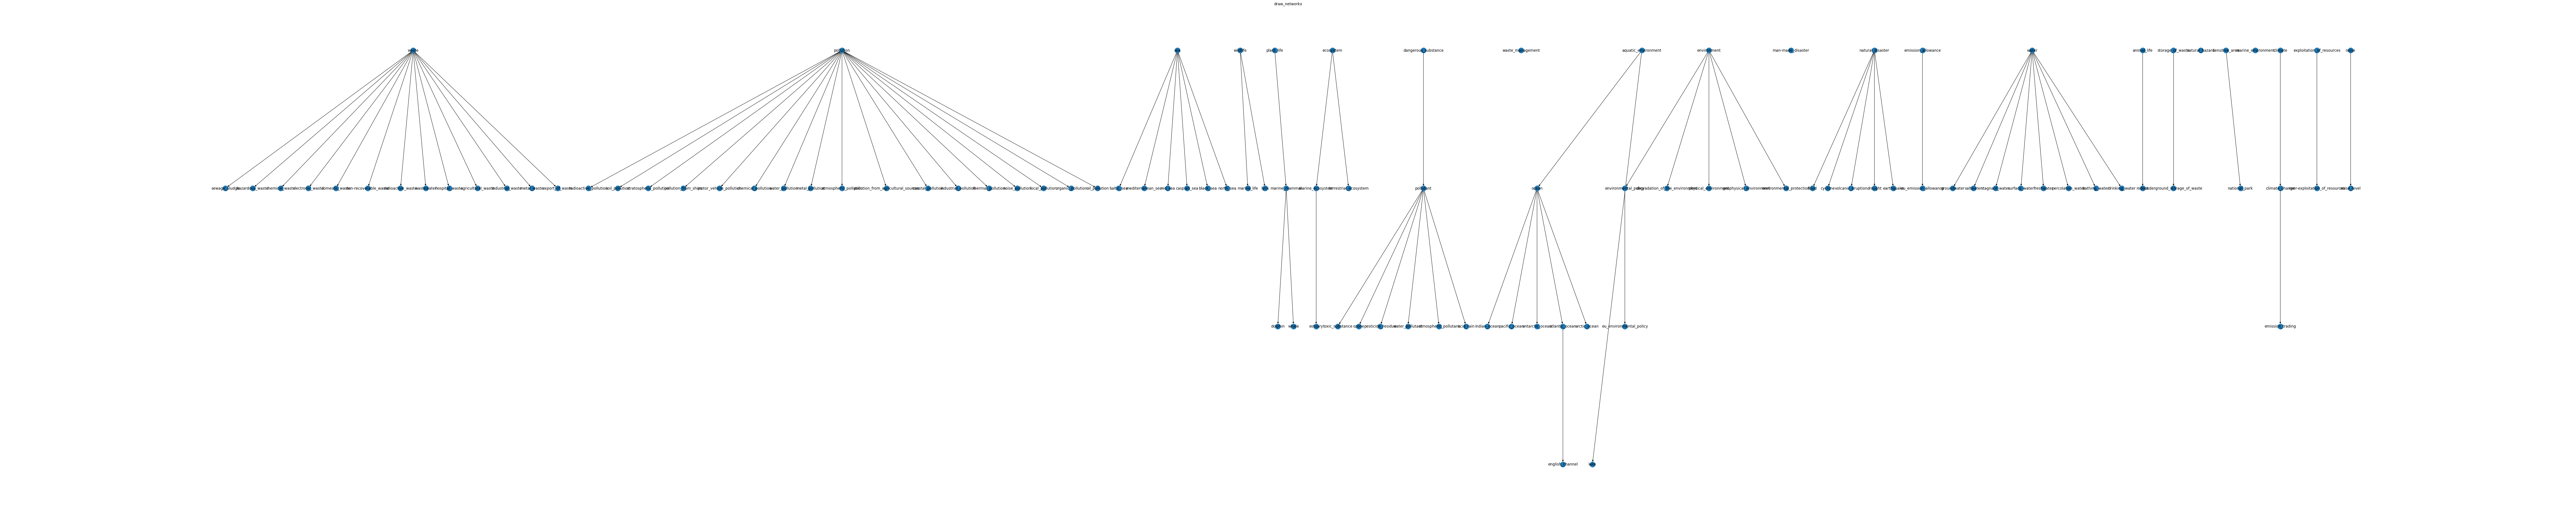

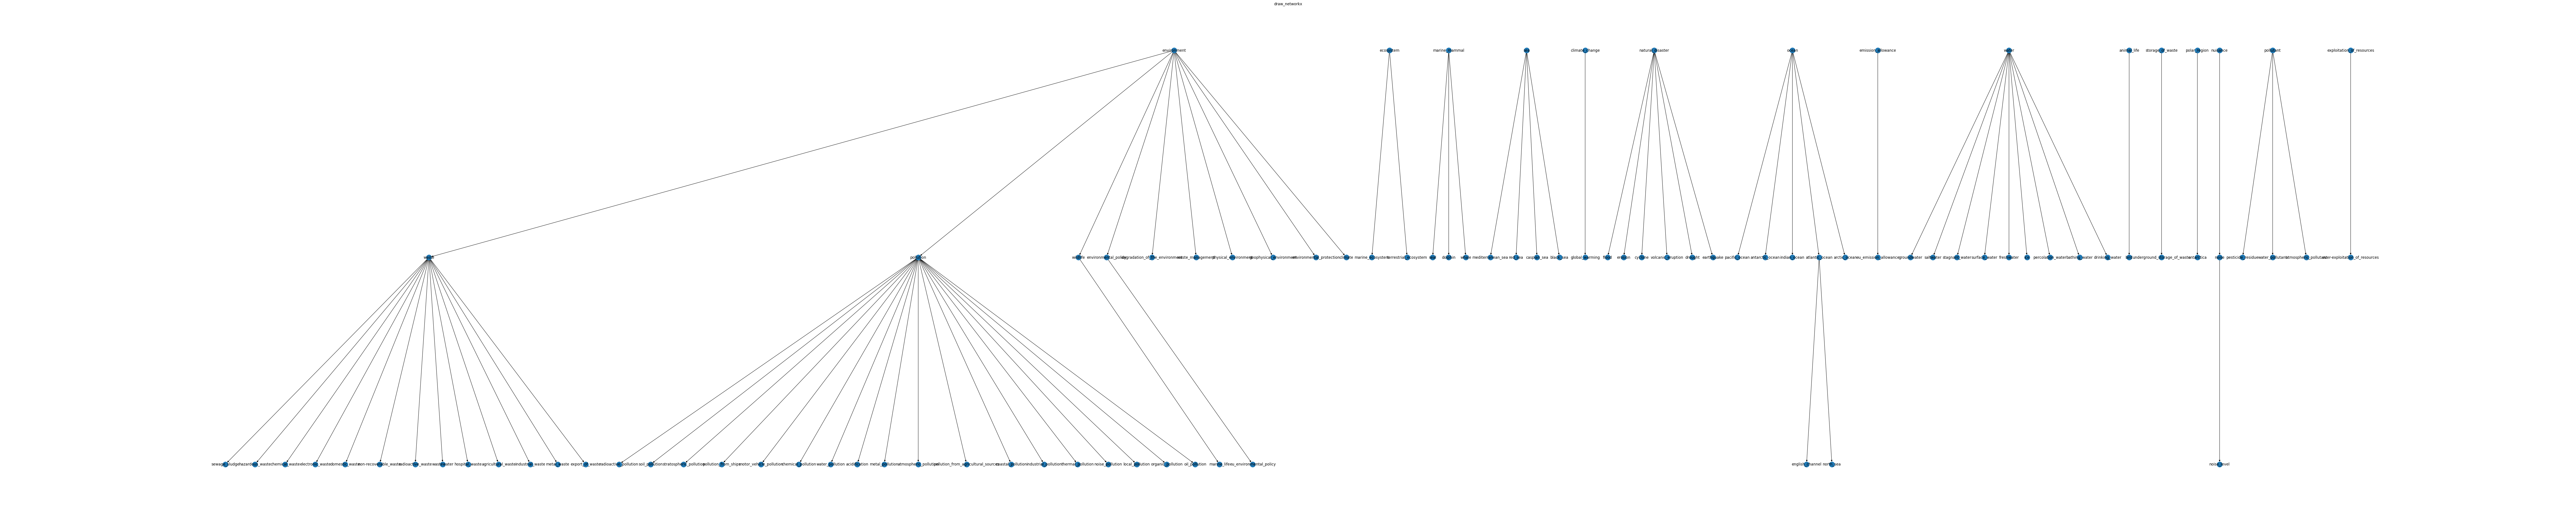

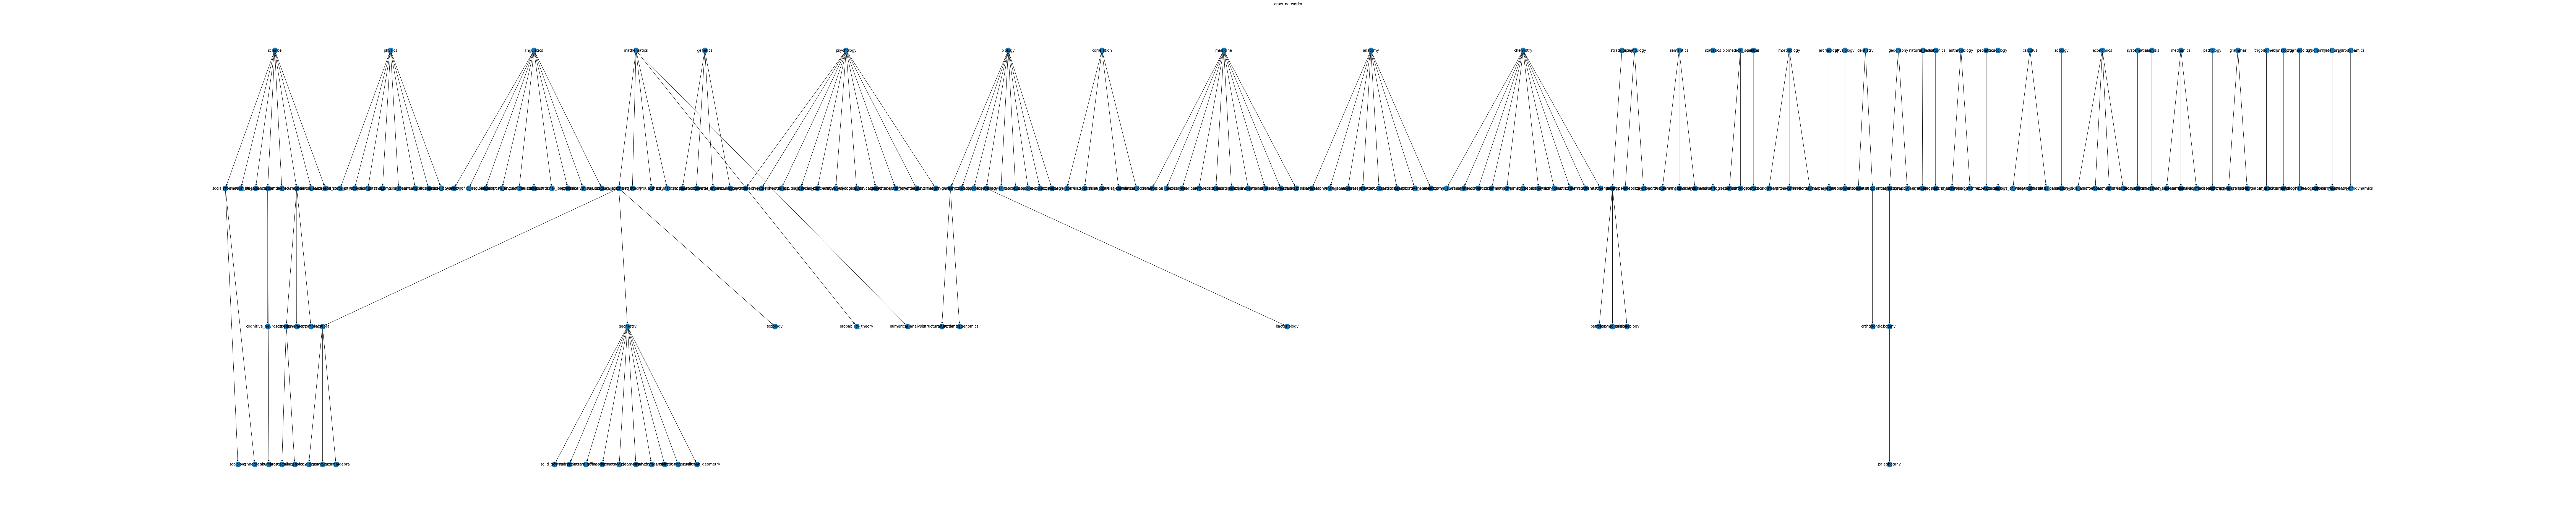

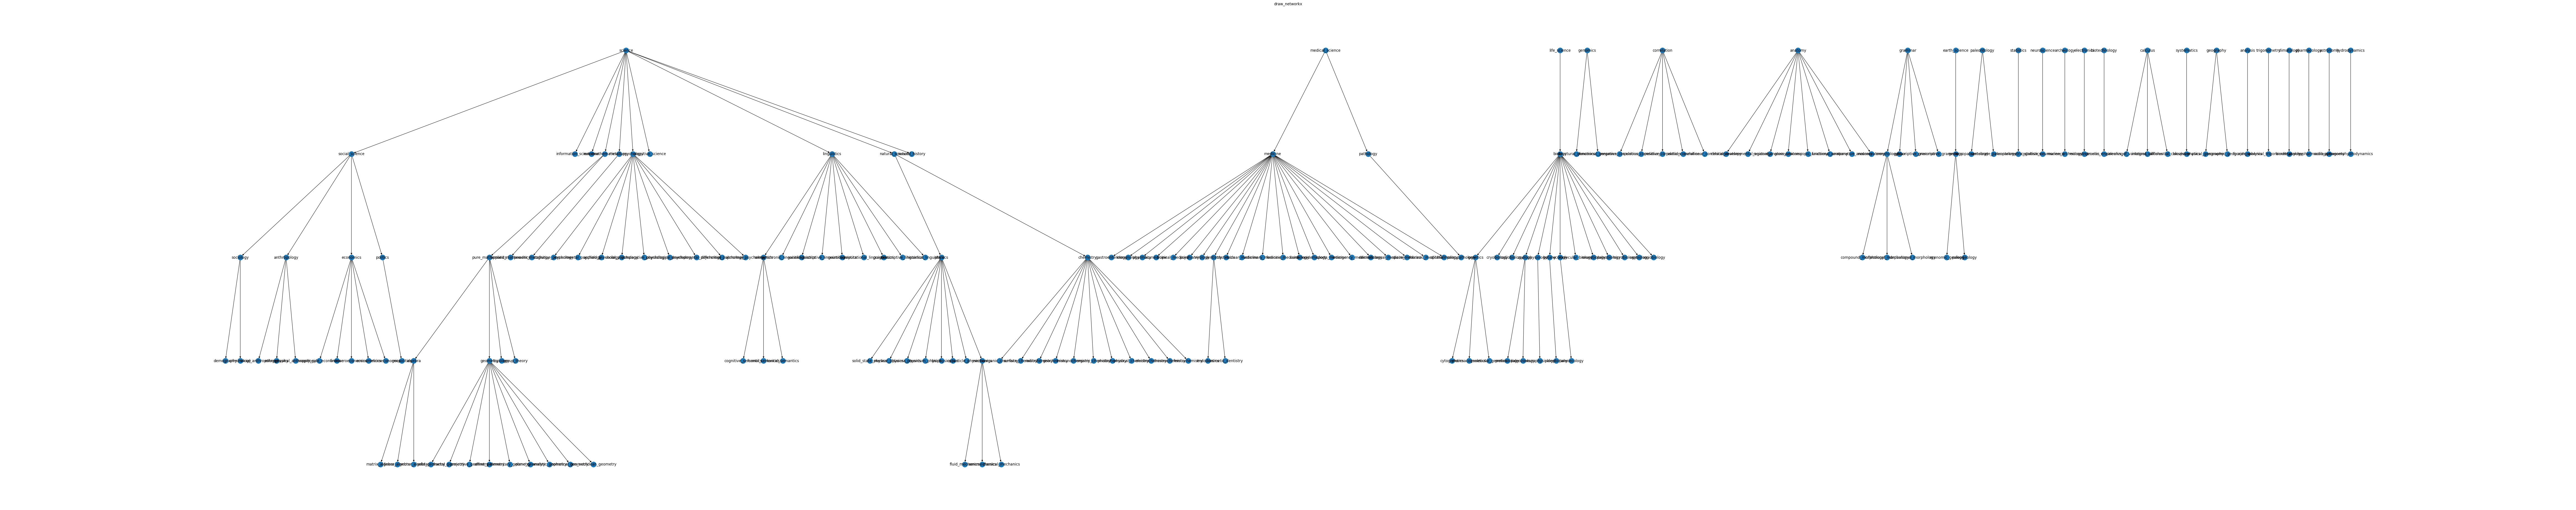

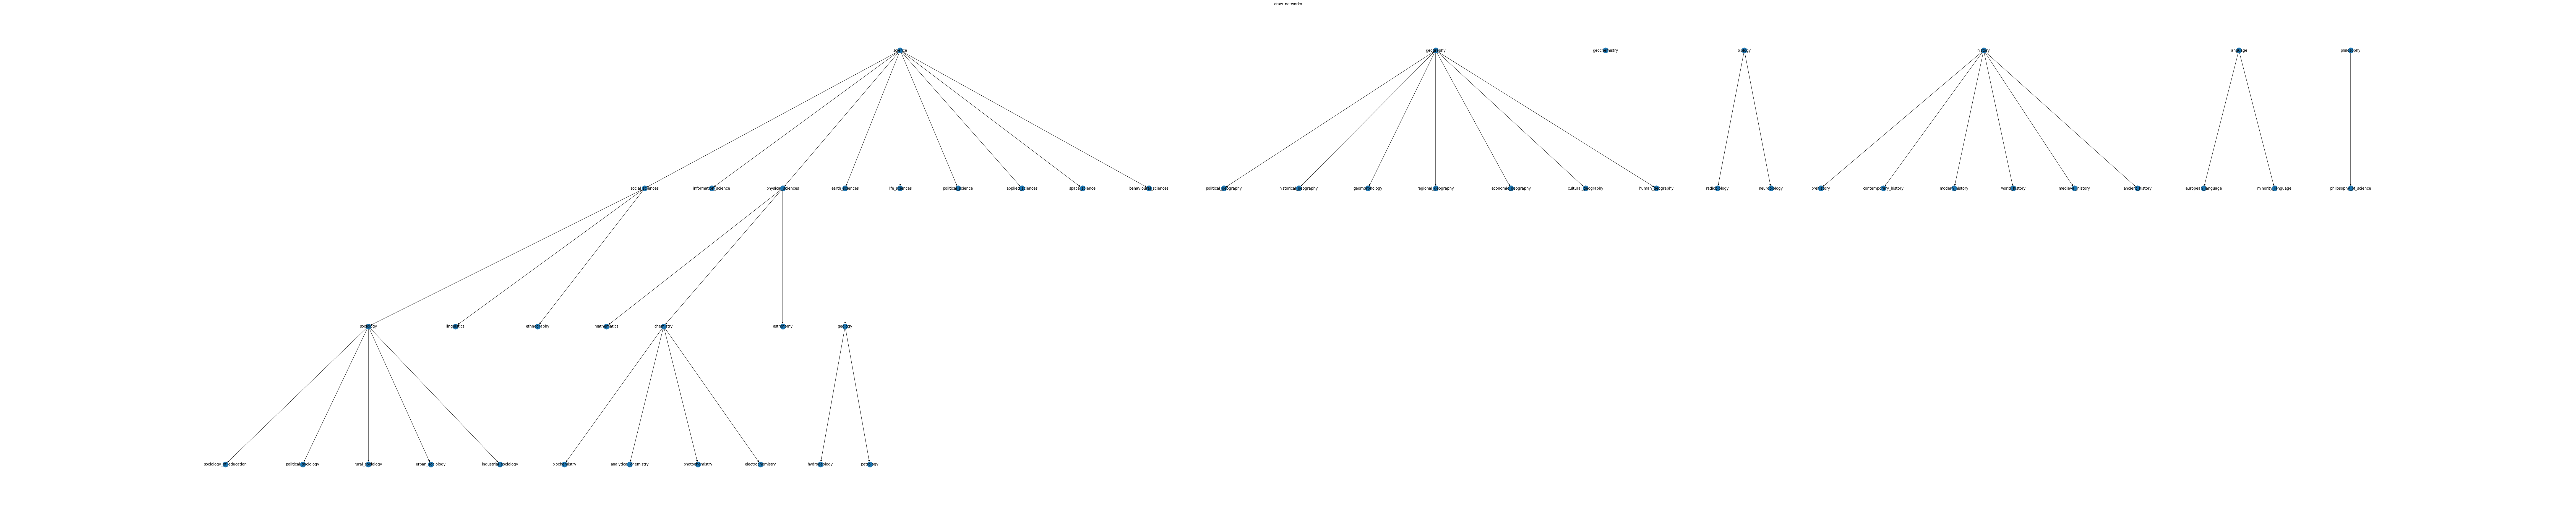

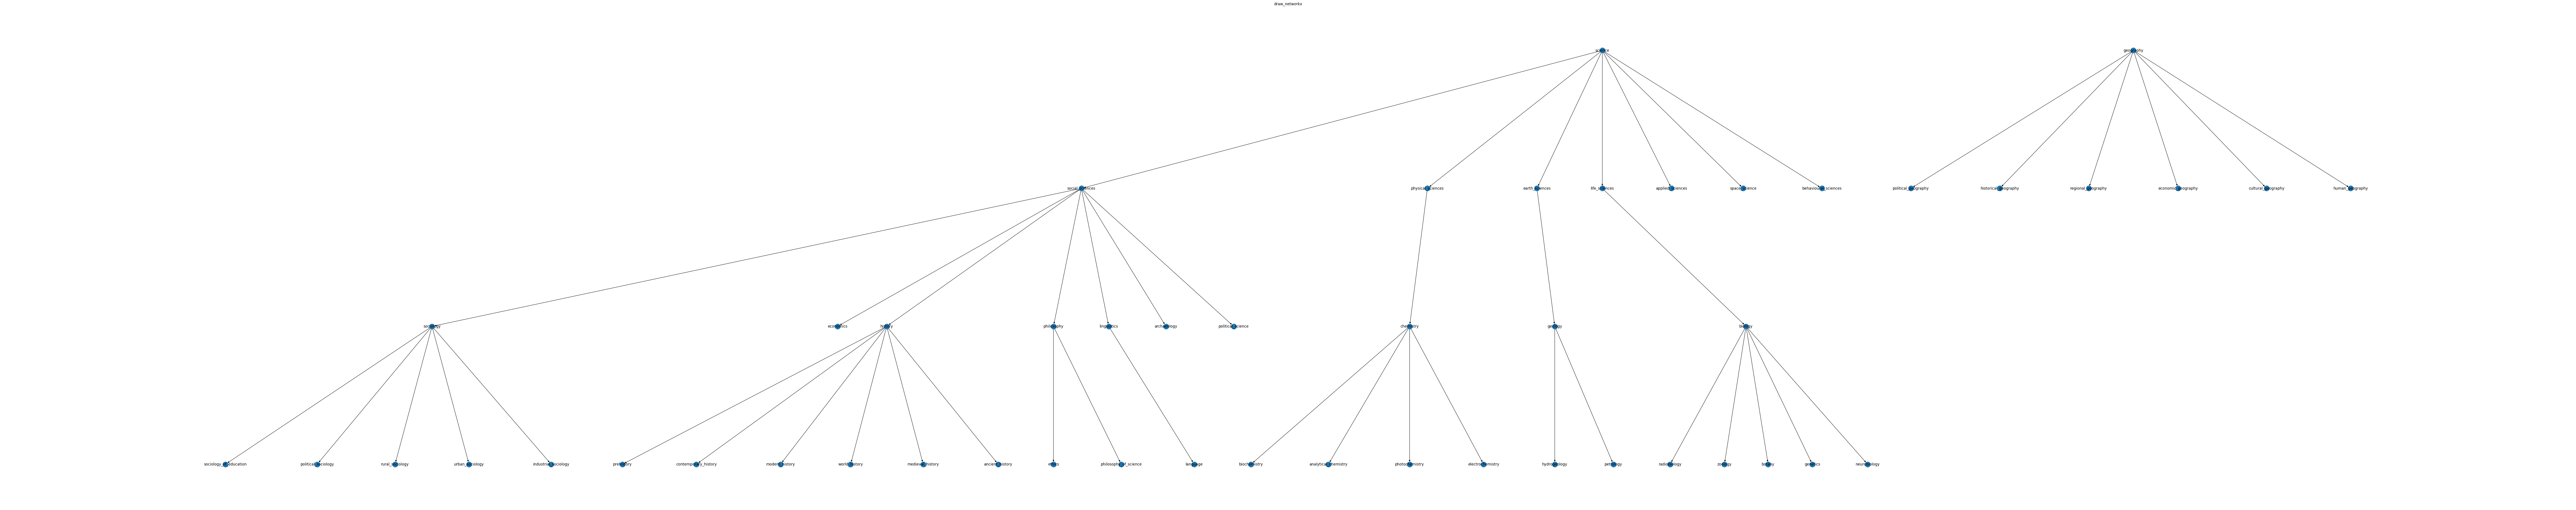

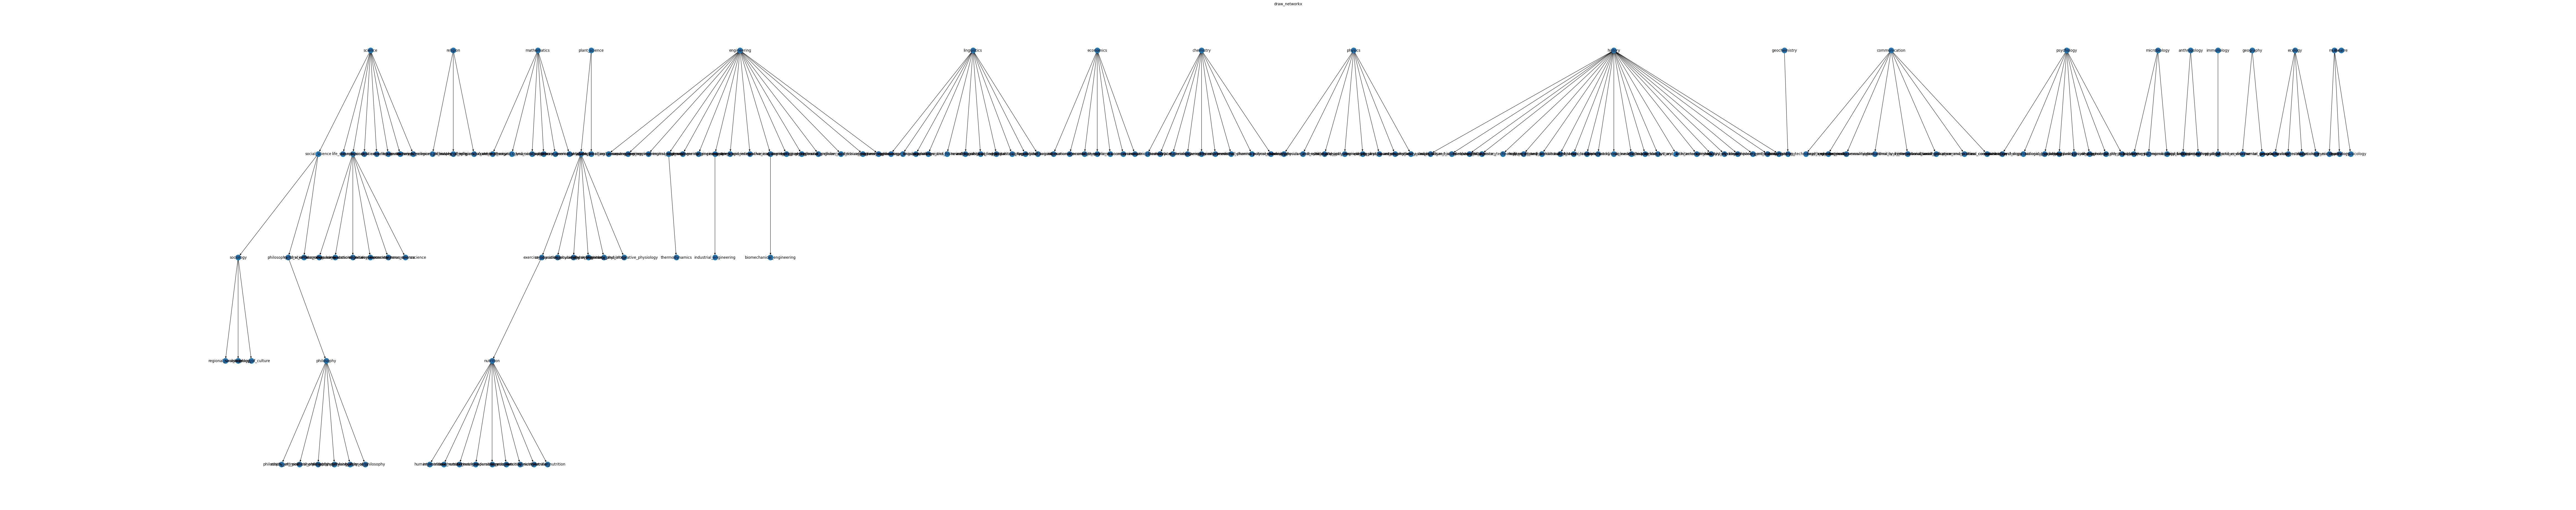

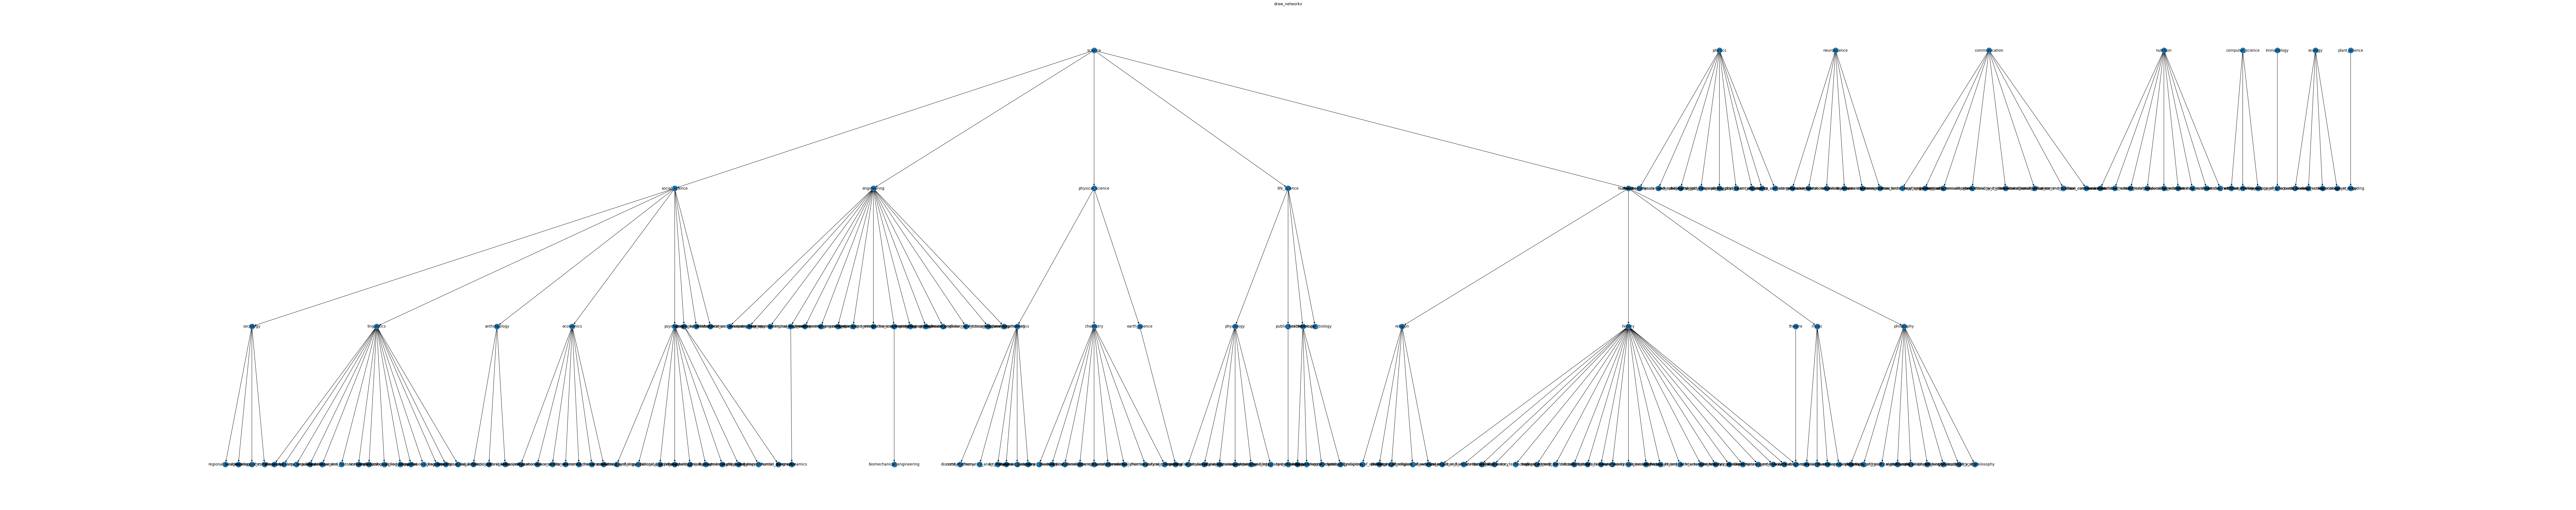

In [88]:
with open('adj_input.pkl', 'rb') as f:
    adj_data = pickle.load(f)
terms_dict = adj_data[3]
index_word_map = {v: k for k, v in terms_dict.items()}

names = ["environment eurovoc en", "science eurovoc en", "science wordnet en", "science en"]
for i, name in enumerate(names):
    e1, e2, pred, label = inference(i)
    pred_g, gt_g = build_graph(e1, e2, pred, label)
    pred_tree = optimize_g(pred_g)

    draw_g(pred_tree, f"pics/pred_{name}.png")
    draw_g(gt_g, f"pics/gt_{name}.png")
